In [3]:
import os

import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import pandas as pd
import numpy as np
from PIL import Image
from IPython.display import display

%load_ext autoreload

%autoreload 2
%matplotlib inline

In [4]:
dataset_file = pd.read_csv("../data/final_dataset.csv")
dataset_file.head()

,sequence,image_sequence,file,label,site,date,camera,sequence_image_count,has_animal,set
0,2,image1,290716114012001a1116.JPG,BIRD,001a,7/29/2016 11:40,111,3,1,train
1,12,image1,100816090812001a1111.JPG,BIRD,001a,8/10/2016 9:08,111,3,1,train
2,17,image1,180516121622001a1602.JPG,BIRD,001a,5/18/2016 12:16,160,3,1,train
3,18,image1,260416120224001a1601.JPG,BIRD,001a,4/26/2016 12:02,160,3,1,train
4,20,image1,160516023810001a1606.JPG,CAT,001a,5/16/2016 2:38,160,3,1,test


In [5]:
dataset_file['time'] = pd.to_datetime(dataset_file.date).dt.time

In [6]:
train_subset = dataset_file[dataset_file.set == 'train']
background_subset = train_subset[train_subset.has_animal == 0]

In [7]:
cam_loc_1 = background_subset[((background_subset.camera == '111') & (background_subset.site=='001a'))]

In [8]:
(background_subset.groupby(['site', 'camera']).count()//3).reset_index()

,site,camera,sequence,image_sequence,file,label,date,sequence_image_count,has_animal,set,time
0,001a,111,69,69,69,69,69,69,69,69,69
1,001a,160,1,1,1,1,1,1,1,1,1
2,001a,s07,3,3,3,3,3,3,3,3,3
3,001a,s46,19,19,19,19,19,19,19,19,19
4,001b,923,14,14,14,14,14,14,14,14,14
...,...,...,...,...,...,...,...,...,...,...,...
603,956,590,31,31,31,31,31,31,31,31,31
604,956,L17,8,8,8,8,8,8,8,8,8
605,985,330,18,18,18,18,18,18,18,18,18
606,985,S18,14,14,14,14,14,14,14,14,14


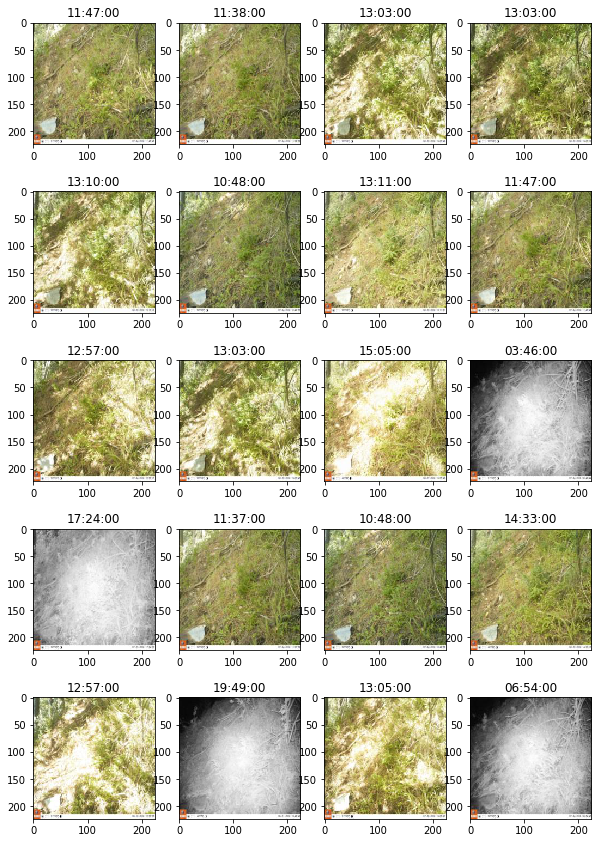

In [9]:
plt.figure(figsize=(10, 15))
for idx, filename in cam_loc_1.sample(20).reset_index(drop=True).iterrows():
    ax = plt.subplot(5, 4, idx + 1)
    plt.imshow(imread(os.path.join('../data/images/images-resized', filename.file)))
    plt.title(filename.time)

### Site camera combo analysis

In [12]:
all_site_cam_combo = list(set(map(lambda a: (a[0], a[1]), train_subset[['site', 'camera']].values)))

030b 502
3
(224, 224, 3)


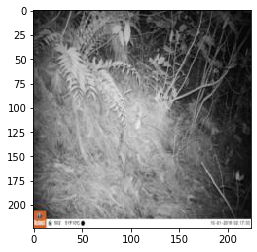

In [26]:
for site, camera in all_site_cam_combo:
    print(site, camera)
    background_list = train_subset[(train_subset.site == site) & 
                                        (train_subset.camera == camera) & 
                                        (train_subset.has_animal == 0)]
    images = []
    print(len(background_list))
    for filename in background_list.file:
        images.append(imread(os.path.join('../data/images/images-resized', filename)))
        
    median_image = np.median(np.array(images), axis=0).astype(np.int32)
    print(median_image.shape)
    plt.imshow(median_image)
    break

### Simple background differencing

In [27]:
train_subset.head()

,sequence,image_sequence,file,label,site,date,camera,sequence_image_count,has_animal,set,time
0,2,image1,290716114012001a1116.JPG,BIRD,001a,7/29/2016 11:40,111,3,1,train,11:40:00
1,12,image1,100816090812001a1111.JPG,BIRD,001a,8/10/2016 9:08,111,3,1,train,09:08:00
2,17,image1,180516121622001a1602.JPG,BIRD,001a,5/18/2016 12:16,160,3,1,train,12:16:00
3,18,image1,260416120224001a1601.JPG,BIRD,001a,4/26/2016 12:02,160,3,1,train,12:02:00
5,22,image1,100516120628001a1604.JPG,BIRD,001a,5/10/2016 12:06,160,3,1,train,12:06:00


In [28]:
def get_pivoted_subset(data, subset):
    subset_data = data.loc[data.set == subset]
    pivoted_data = subset_data.pivot(index='sequence', 
                                     columns='image_sequence', 
                                     values='file').reset_index()
    pivoted_data.columns.name = None
    label_mapper = data[['sequence', 'has_animal']].drop_duplicates('sequence')\
                   .set_index('sequence').to_dict()['has_animal']
    pivoted_data['has_animal'] = pivoted_data.sequence.map(label_mapper.get)
    return pivoted_data

In [76]:
pivoted_train_data = get_pivoted_subset(train_subset, 'train')
pivoted_train_data = pivoted_train_data[pivoted_train_data.has_animal == 1].reset_index(drop=True)
pivoted_train_data.head()

,sequence,image1,image2,image3,has_animal
0,2,290716114012001a1116.JPG,290716114014001a1114.JPG,290716114014001a1115.JPG,1
1,11,100816185652001a1111.JPG,100816185652001a1112.JPG,100816185652001a1113.JPG,1
2,12,100816090812001a1111.JPG,100816090812001a1112.JPG,100816090812001a1113.JPG,1
3,13,090816194736001a1112.JPG,090816194736001a1113.JPG,090816194738001a1111.JPG,1
4,15,050816144738001a1111.JPG,050816144738001a1112.JPG,050816144738001a1113.JPG,1


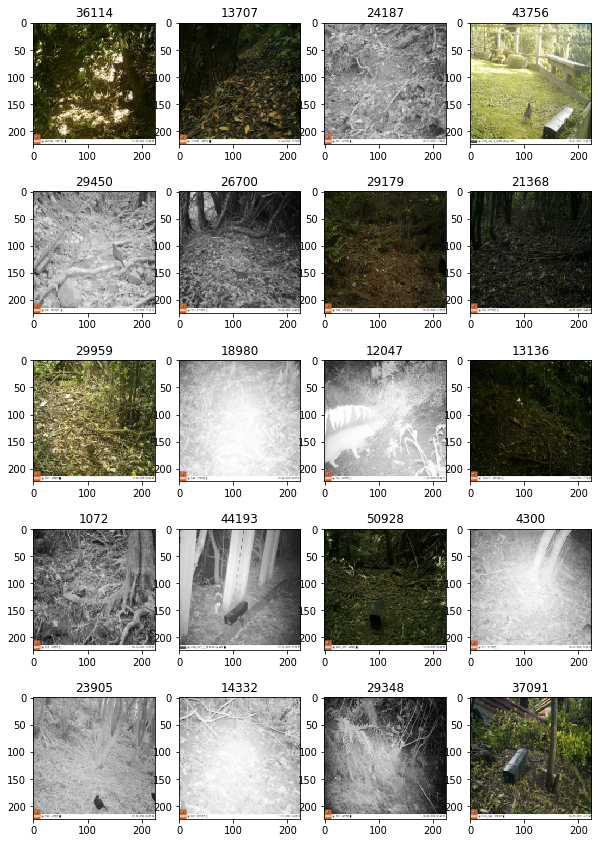

In [95]:
plt.figure(figsize=(10, 15))
for idx, filename in pivoted_train_data.sample(20).reset_index().iterrows():
    ax = plt.subplot(5, 4, idx + 1)
    plt.imshow(imread(os.path.join('../data/images/images-resized', filename.image1)))
    plt.title(str(filename['index']))

In [90]:
pivoted_train_data.reset_index().head()

,index,sequence,image1,image2,image3,has_animal
0,0,2,290716114012001a1116.JPG,290716114014001a1114.JPG,290716114014001a1115.JPG,1
1,1,11,100816185652001a1111.JPG,100816185652001a1112.JPG,100816185652001a1113.JPG,1
2,2,12,100816090812001a1111.JPG,100816090812001a1112.JPG,100816090812001a1113.JPG,1
3,3,13,090816194736001a1112.JPG,090816194736001a1113.JPG,090816194738001a1111.JPG,1
4,4,15,050816144738001a1111.JPG,050816144738001a1112.JPG,050816144738001a1113.JPG,1


(224, 224, 4)


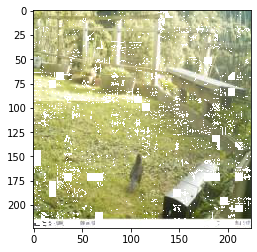

In [118]:
def get_difference_image(data_row):
    img1 = imread(os.path.join("../data/images/images-resized/", data_row.image1))
    img2 = imread(os.path.join("../data/images/images-resized/", data_row.image2))
    img3 = imread(os.path.join("../data/images/images-resized/", data_row.image3))
    
    diff12 = np.isclose(img1, img2)
    diff13 = np.isclose(img1, img3)
    diff23 = np.isclose(img2, img3)
    
    diff_img = np.logical_and(diff12, diff13, diff23)
    
#     diff_img = np.logical_and(img1 == img2, img2 == img3, img1 == img3)
    diff_img = np.logical_not(np.logical_and(diff_img[:, :, 0], 
                                             diff_img[:, :, 1], 
                                             diff_img[:, :, 2])).astype(np.uint8) * 255
    diff_img = np.dstack((img1, diff_img))
    print(diff_img.shape)
    plt.imshow(diff_img)
#     plt.imshow(img2)
    
    
get_difference_image(pivoted_train_data.loc[43756])